# Fine-tuning to Follow Instructions

## Overview

This notebook demonstrates how to fine-tune a pre-trained GPT-2 model to follow instructions. This process is known as **Supervised Fine-Tuning (SFT)** or **Instruction Tuning**, which is a critical step in creating AI assistants like ChatGPT.

### What is Instruction Fine-Tuning?

Instruction fine-tuning transforms a base language model (trained only to predict the next token) into a model that can understand and respond to user instructions. The key differences are:

- **Base Model**: Predicts the next most likely token based on the training corpus
- **Instruction-Tuned Model**: Understands task descriptions and generates appropriate responses

### What We'll Cover

1. **Data Preparation**: Loading and formatting instruction-response pairs
2. **Dataset Creation**: Building a custom PyTorch Dataset for instruction data
3. **Batching Strategy**: Implementing custom collate functions with proper padding and masking
4. **Model Loading**: Loading pre-trained GPT-2 weights
5. **Training**: Fine-tuning the model on instruction data
6. **Evaluation**: Testing the model's ability to follow instructions

### The Alpaca Format

We'll use the popular Alpaca instruction format:
```
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{optional input}

### Response:
{model output}
```

## 1. Environment Setup

First, we install the required dependencies:
- **torch**: PyTorch deep learning framework for model training
- **tiktoken**: OpenAI's fast BPE tokenizer (used by GPT models)
- **transformers**: Hugging Face library (for reference implementations)

In [3]:
!pip install torch tiktoken transformers

## 2. Loading the Instruction Dataset

We'll download and load an instruction-following dataset. This dataset contains 1,100 instruction-response pairs in JSON format.

Each entry has three fields:
- **instruction**: The task description (e.g., "Identify the correct spelling")
- **input**: Optional additional context or data for the task
- **output**: The expected response

The `download_and_load_file` function:
1. Downloads the JSON file if it doesn't exist locally
2. Loads and parses the JSON data
3. Returns a list of dictionaries containing the instruction data

In [4]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)


data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


### 2.1 Exploring the Dataset Structure

Let's examine individual entries to understand the data format. We'll look at two types of examples:
1. An entry **with input** - where additional context is provided
2. An entry **without input** - where only the instruction is given

This distinction is important because our formatting function will need to handle both cases.

In [5]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [6]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


Notice that entry 999 has an **empty input field**. This is common for simple Q&A tasks where the instruction itself contains all necessary information.

In [7]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    return instruction_text + input_text

## 3. Formatting Instructions for the Model

The `format_input` function converts our data entries into the **Alpaca prompt format**. This standardized format helps the model understand:

1. **System context**: "Below is an instruction that describes a task..."
2. **Instruction section**: The actual task to perform
3. **Input section**: Optional additional context (only included if present)

The format uses special markers (`### Instruction:`, `### Input:`, `### Response:`) to clearly delineate different parts of the prompt. This structured approach helps the model learn the pattern of instruction-following.

In [8]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


### 3.1 Visualizing the Complete Training Format

Let's see what the complete formatted text looks like. During training, we provide the model with:
- The formatted input (instruction + optional input)
- The `### Response:` marker
- The expected output

The model learns to generate the response when given the instruction format.

In [9]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


Here's an example **without an input field**. Notice that the format adapts and excludes the `### Input:` section entirely.

In [10]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 4. Splitting the Dataset

We split our data into three sets following standard ML practice:

| Split | Percentage | Size | Purpose |
|-------|------------|------|---------|
| **Training** | 85% | 935 | Train the model |
| **Test** | 10% | 110 | Final evaluation |
| **Validation** | 5% | 55 | Hyperparameter tuning & monitoring |

The validation set is used during training to monitor for overfitting, while the test set is held out for final evaluation only.

In [11]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

## 5. Creating a Custom PyTorch Dataset

The `InstructionDataset` class wraps our instruction data for PyTorch's DataLoader. Key features:

1. **Pre-tokenization**: All texts are tokenized during initialization for efficiency
2. **Format application**: Each entry is formatted using our `format_input` function
3. **Response concatenation**: The response is appended with the `### Response:` marker

This design allows the DataLoader to efficiently batch the pre-tokenized sequences during training.

In [12]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


### 5.1 Setting Up the Tokenizer

We use the GPT-2 BPE tokenizer via `tiktoken`. The special token `<|endoftext|>` (ID: 50256) serves as:
- **End-of-sequence marker**: Signals when generation should stop
- **Padding token**: Used to pad shorter sequences in a batch (since GPT-2 doesn't have a dedicated padding token)

In [13]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]


        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

## 6. Building the Collate Function (Step by Step)

A **collate function** tells PyTorch how to combine individual samples into a batch. For language models, this is challenging because sequences have different lengths.

### 6.1 Draft 1: Basic Padding

Our first draft pads all sequences to the maximum length in the batch:
1. Find the longest sequence in the batch
2. Add an end-of-text token to each sequence
3. Pad shorter sequences with the padding token (50256)

This creates uniform-length tensors that can be batched together.

In [14]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


Let's test our first draft with simple example sequences. Notice how shorter sequences (like `[5, 6]`) are padded with 50256 to match the longest sequence length.

In [15]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


### 6.2 Draft 2: Adding Targets

For language model training, we need both **inputs** and **targets**:
- **Inputs**: The sequence the model sees
- **Targets**: The sequence shifted by one position (what the model should predict)

This is the standard next-token prediction setup: given tokens `[0, 1, 2, 3, 4]`, the model should predict `[1, 2, 3, 4, <end>]`.

In [16]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]


        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

### 6.3 Final Version: Masking Padding in Loss Calculation

**The Problem**: If we compute loss on padding tokens, the model wastes capacity learning to predict padding, which is meaningless.

**The Solution**: Replace padding tokens in targets (except the first one) with `-100`, PyTorch's special "ignore" index. When computing cross-entropy loss, positions with `-100` are excluded.

**Why keep the first padding token?** The first padding token after real content is actually the end-of-text token we added - we want the model to learn when to stop generating!

Additional features:
- `allowed_max_length`: Optionally truncate sequences to a maximum length (useful for memory constraints)

In [17]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


Now we can see the `-100` values in targets where padding occurs (after the first end-of-text token). These positions will be ignored during loss calculation.

In [18]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5]]
)
targets_1 = torch.tensor([0, 1]) # Correct token indices to generate
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


## 7. Understanding Cross-Entropy Loss with Ignore Index

Let's demonstrate how PyTorch's `cross_entropy` loss handles the ignore index (`-100`).

### Example 1: Basic Loss Calculation
We compute loss for 2 samples with their correct target indices. The loss averages over both samples.

In [19]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]
)
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


### Example 2: Adding a Third Sample
With 3 samples, the loss is different because we're averaging over more examples.

In [20]:
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


### Example 3: Using Ignore Index (-100)
When we set the third target to `-100`, it's **completely ignored** in the loss calculation. The loss becomes identical to Example 1 (2 samples), proving that `-100` targets don't contribute to training.

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.backends.mps.is_available():
#     device = torch.device("mps")"      
print("Device:", device)

Device: cuda


## 8. Setting Up the Device

We configure the compute device:
- **CUDA**: For NVIDIA GPUs (fastest)
- **MPS**: For Apple Silicon (commented out)
- **CPU**: Fallback option

Training on GPU is significantly faster than CPU for transformer models.

In [22]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

### 8.1 Creating a Customized Collate Function

We use `functools.partial` to create a collate function with pre-set parameters:
- **device**: Where to place the tensors
- **allowed_max_length**: Maximum sequence length (1024 tokens, matching GPT-2's context window)

This allows us to pass a parameterized collate function to the DataLoader.

In [23]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

## 9. Creating DataLoaders

We create three DataLoaders with our custom collate function:

| DataLoader | Batch Size | Shuffle | Drop Last |
|------------|------------|---------|-----------|
| **Train** | 8 | Yes | Yes |
| **Validation** | 8 | No | No |
| **Test** | 8 | No | No |

- **shuffle=True**: Randomizes training order each epoch (prevents learning order-dependent patterns)
- **drop_last=True**: Drops incomplete final batch (ensures consistent batch sizes during training)
- For validation/test, we keep all samples and don't shuffle to ensure reproducibility

In [24]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

### 9.1 Inspecting Batch Shapes

Let's verify our DataLoader is working correctly. Each batch has a different shape because sequences are padded to the maximum length within that specific batch (not globally). This is efficient because shorter batches use less memory.

In [25]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

## 10. Model Configuration

We configure the GPT-2 model architecture. Several model sizes are available:

| Model | Parameters | Embedding Dim | Layers | Heads |
|-------|------------|---------------|--------|-------|
| GPT-2 Small | 124M | 768 | 12 | 12 |
| GPT-2 Medium | 355M | 1024 | 24 | 16 |
| GPT-2 Large | 774M | 1280 | 36 | 20 |
| GPT-2 XL | 1558M | 1600 | 48 | 25 |

We'll use **GPT-2 Small (124M)** for faster training. Key configuration:
- **vocab_size**: 50,257 (GPT-2's vocabulary)
- **context_length**: 1,024 tokens (maximum sequence length)
- **drop_rate**: 0.0 (no dropout for fine-tuning)
- **qkv_bias**: True (include bias in attention projections)

In [26]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7bb80e9700b0>)

### 10.1 Downloading Helper Scripts

We download the `gpt_download.py` script which contains utilities for downloading pre-trained GPT-2 weights from OpenAI.

In [27]:
import torch.nn as nn

## 11. Defining the GPT-2 Model Architecture

Now we define all the building blocks of the GPT-2 architecture from scratch. This includes:

1. **LayerNorm**: Normalizes activations for training stability
2. **MultiHeadAttention**: The core self-attention mechanism
3. **GELU**: Activation function used in transformers
4. **FeedForward**: MLP layers in each transformer block
5. **TransformerBlock**: Complete transformer layer (attention + FFN)
6. **GPTModel**: The full GPT-2 model

### 11.1 Layer Normalization

LayerNorm normalizes across the feature dimension, helping stabilize training. It has learnable scale and shift parameters.

In [28]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

### 11.2 Multi-Head Self-Attention

The attention mechanism allows tokens to "attend" to other tokens in the sequence. Key concepts:

- **Query, Key, Value projections**: Linear transformations for attention computation
- **Multiple heads**: Allows attending to different aspects of the input in parallel
- **Causal masking**: Prevents tokens from attending to future tokens (autoregressive property)
- **Scaled dot-product attention**: `softmax(QK^T / sqrt(d_k)) * V`

In [29]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, 
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)  
        queries = queries.view(                                             
            b, num_tokens, self.num_heads, self.head_dim                    
        )                                                                   

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)
        return context_vec

### 11.3 GELU Activation Function

GELU (Gaussian Error Linear Unit) is the activation function used in GPT-2. Unlike ReLU, it provides a smooth approximation that can output small negative values, which helps with gradient flow.

In [30]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

### 11.4 Feed-Forward Network and Transformer Block

Each transformer block consists of:
1. **Layer Norm → Multi-Head Attention → Residual Connection**
2. **Layer Norm → Feed-Forward Network → Residual Connection**

The **Feed-Forward Network** expands the embedding dimension by 4x, applies GELU, then projects back. This allows the model to learn complex transformations.

**Residual connections** (skip connections) add the input to the output, helping gradient flow and enabling deeper networks.

In [31]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)
    
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

### 11.5 Complete GPT Model

The full GPT model combines:
1. **Token embeddings**: Convert token IDs to vectors
2. **Positional embeddings**: Add position information (learned, not sinusoidal)
3. **Embedding dropout**: Regularization
4. **Transformer blocks**: Stack of N transformer layers
5. **Final layer norm**: Normalize before output projection
6. **Output head**: Project to vocabulary size for next-token prediction

In [32]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## 12. Loading Pre-trained GPT-2 Weights

Now we need to load the pre-trained weights from OpenAI's GPT-2 into our model architecture. This requires careful mapping between OpenAI's weight format and our model structure.

### 12.1 Weight Assignment Helper

The `assign` function ensures shapes match when copying weights, preventing silent errors.

In [33]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                          "Right: {right.shape}"
        )
    return torch.nn.Parameter(torch.tensor(right))

### 12.2 Weight Loading Function

The `load_weights_into_gpt` function maps OpenAI's GPT-2 weights to our model:

- **Position/Token embeddings**: Direct assignment (`wpe`, `wte`)
- **Attention weights**: Split combined QKV weights into separate Q, K, V matrices
- **Feed-forward weights**: Map `c_fc` (expand) and `c_proj` (contract) layers
- **Layer norms**: Map `ln_1`, `ln_2` (in blocks) and final layer norm
- **Output head**: Tied to token embeddings (weight sharing)

In [34]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

### 12.3 Download and Load Pre-trained Model

We download the GPT-2 weights from OpenAI (if not already cached) and load them into our model. The model is set to evaluation mode (`model.eval()`) to disable dropout for inference.

In [35]:
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size, 
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

## 13. Testing the Pre-trained Model (Before Fine-tuning)

Before fine-tuning, let's see how the base GPT-2 model responds to our instruction format. Since it was only trained on next-token prediction, it doesn't understand the instruction format and will likely generate nonsensical or repetitive output.

### 13.1 Prepare Test Input

We format an instruction from our validation set using our Alpaca format.

In [36]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


### 13.2 Text Generation Functions

We define helper functions for text generation:

- **generate_text_simple**: Basic greedy decoding (always picks the most likely token)
- **text_to_token_ids**: Converts text to token tensor
- **token_ids_to_text**: Converts token tensor back to text

In [37]:
import tiktoken

def generate_text_simple(model, idx,
                         max_new_tokens, context_size): 
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

### 13.3 Advanced Generation with Sampling

The `generate` function provides more sophisticated decoding options:

- **temperature**: Controls randomness (0 = greedy, >0 = more random)
- **top_k**: Limits sampling to top-k most likely tokens
- **eos_id**: Stop generation when end-of-sequence token is generated

Temperature scaling divides logits before softmax:
- `temperature < 1`: Sharpens distribution (more confident)
- `temperature > 1`: Flattens distribution (more random)

In [38]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

### 13.4 Generate Response (Pre-fine-tuning)

Let's generate a response using the pre-trained model. We expect poor results since the model hasn't learned to follow instructions.

In [39]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)


In [40]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active


As expected, the pre-trained model doesn't follow the instruction. Instead, it continues the pattern it sees (repeating the instruction format) rather than answering the question. This demonstrates why instruction fine-tuning is necessary.

In [44]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen = 0
    global_step = -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots()

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    # plt.show()

## 14. Training Functions

We define the training infrastructure:

### Helper Functions:

1. **calc_loss_batch**: Computes cross-entropy loss for a single batch
2. **calc_loss_loader**: Averages loss over multiple batches from a DataLoader
3. **evaluate_model**: Computes train and validation loss (in eval mode)
4. **generate_and_print_sample**: Generates sample text to monitor progress
5. **train_model_simple**: Main training loop with periodic evaluation

### Training Loop Components:
- **Optimizer step**: `optimizer.zero_grad()` → `loss.backward()` → `optimizer.step()`
- **Evaluation**: Periodically compute losses on train/val sets
- **Sampling**: Generate text after each epoch to see qualitative progress

### Visualization:
- **plot_losses**: Creates dual-axis plot showing loss vs epochs and tokens

In [45]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.167140197753906
Validation loss: 4.0509357929229735


### 14.1 Baseline Loss (Before Training)

Before training, let's measure the initial loss. This gives us a baseline to compare against after fine-tuning. A loss around 4.0+ is typical for a pre-trained model on a new task.

In [46]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.119, Val loss 3.069
Ep 1 (Step 000005): Train loss 1.696, Val loss 1.570
Ep 1 (Step 000010): Train loss 1.095, Val loss 1.164
Ep 1 (Step 000015): Train loss 1.053, Val loss 1.083
Ep 1 (Step 000020): Train loss 0.970, Val loss 1.038
Ep 1 (Step 000025): Train loss 0.920, Val loss 1.002
Ep 1 (Step 000030): Train loss 0.960, Val loss 0.978
Ep 1 (Step 000035): Train loss 0.878, Val loss 0.951
Ep 1 (Step 000040): Train loss 0.846, Val loss 0.943
Ep 1 (Step 000045): Train loss 0.777, Val loss 0.925
Ep 1 (Step 000050): Train loss 0.869, Val loss 0.911
Ep 1 (Step 000055): Train loss 0.924, Val loss 0.893
Ep 1 (Step 000060): Train loss 0.873, Val loss 0.878
Ep 1 (Step 000065): Train loss 0.800, Val loss 0.866
Ep 1 (Step 000070): Train loss 0.694, Val loss 0.860
Ep 1 (Step 000075): Train loss 0.707, Val loss 0.856
Ep 1 (Step 000080): Train loss 0.754, Val loss 0.847
Ep 1 (Step 000085): Train loss 0.680, Val loss 0.836
Ep 1 (Step 000090): Train loss 0.729, Val loss

## 15. Fine-tuning the Model

Now we fine-tune the model on our instruction dataset!

### Training Configuration:
- **Optimizer**: AdamW (Adam with weight decay)
- **Learning rate**: 5e-5 (small, to avoid destroying pre-trained knowledge)
- **Weight decay**: 0.1 (regularization)
- **Epochs**: 2 (instruction tuning often requires few epochs)
- **Eval frequency**: Every 5 steps

### What to Watch For:
- Loss should decrease rapidly in the first epoch
- Validation loss should track training loss (no overfitting)
- Generated samples should progressively improve

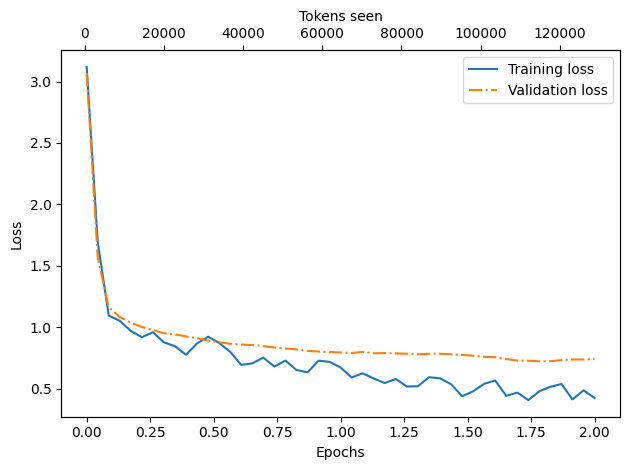

In [48]:
import matplotlib.pyplot as plt
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### 15.1 Visualizing Training Progress

The loss curves show how the model improves during training. Both training and validation loss should decrease, indicating the model is learning the instruction-following task without overfitting.

In [49]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a horse.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a tropical rainforest.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 

## 16. Evaluating the Fine-tuned Model

Now let's test our fine-tuned model on the test set. We'll compare:
- The **correct response** (ground truth)
- The **model's response** (generated)

Note: The model may not always give perfectly correct answers (e.g., factual knowledge), but it should now understand the instruction format and generate relevant responses.

In [50]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [00:29<00:00,  3.75it/s]


### 16.1 Generate Responses for All Test Data

Let's generate responses for the entire test set and save them. This allows for later analysis and comparison with other models or evaluation methods.

In [51]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a horse.'}


### 16.2 Inspect Sample Response

Let's look at the structure of a test sample with its model-generated response. Each entry now has a `model_response` field alongside the original `output`.

In [52]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-small124M-sft.pth


## 17. Saving the Fine-tuned Model

Finally, we save the fine-tuned model weights for later use. The model is saved using PyTorch's `state_dict` format, which stores all learned parameters.

## Summary and Key Takeaways

In this notebook, we successfully fine-tuned GPT-2 to follow instructions. Here are the key lessons:

### What We Learned:

1. **Instruction Format**: The Alpaca format (`### Instruction:`, `### Input:`, `### Response:`) provides structure that helps the model learn when to respond.

2. **Custom Collate Functions**: Variable-length sequences require careful batching with proper padding and masking to avoid training on padding tokens.

3. **Ignore Index (-100)**: PyTorch's cross-entropy loss ignores targets with value `-100`, allowing us to exclude padding from loss calculation.

4. **Fine-tuning vs Pre-training**: 
   - Pre-trained model: Only predicts next tokens, doesn't understand instructions
   - Fine-tuned model: Follows instructions and generates appropriate responses

5. **Training Efficiency**: With just ~1000 examples and 2 epochs (~30 seconds on GPU), we achieved significant improvement in instruction-following ability.

### Limitations:

- The model may hallucinate factual information (it learned the format, not new knowledge)
- Small model (124M params) limits capability compared to larger models
- No RLHF (Reinforcement Learning from Human Feedback) for further alignment

### Next Steps:

- Evaluate using automated metrics (BLEU, ROUGE, or LLM-as-judge)
- Try larger models (GPT-2 Medium/Large) for better quality
- Experiment with more training data or different instruction datasets
- Apply techniques like LoRA for more efficient fine-tuning